<a href="https://www.kaggle.com/code/nerdyalgorithm/homework-3-machine-learning-for-classification?scriptVersionId=268101502" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Homework 3: Machine Learning for Classification - ml zoomcamp
> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the lead scoring dataset Bank Marketing dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not. 

### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw04
* If your answer doesn't match options exactly, select the closest one


---
## SET UP

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt


---
## LOAD DATA

In [2]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df = pd.read_csv(url)
df.head()


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


---
## CHECK AND HANDLE NISSING VALUE

In [3]:
# Check missing values
df.isnull().sum()

# Separate categorical and numerical features
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Fill missing values
for c in cat_cols:
    df[c] = df[c].fillna('NA')

for c in num_cols:
    df[c] = df[c].fillna(0.0)


---
## SPLIT DATA

In [4]:
# Target variable
y = df.converted.values

# Split 60/20/20
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  # 0.25 * 0.8 = 0.2

y_train = df_train.converted.values
y_val = df_val.converted.values


---
### Question 1: ROC AUC feature importance

In [5]:
num_vars = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

for c in num_vars:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print(f"{c}: {auc:.3f}")


lead_score: 0.614
number_of_courses_viewed: 0.764
interaction_count: 0.738
annual_income: 0.552


---

## Question 2 — Train Logistic Regression

In [6]:
# Prepare features (exclude target)
train_dicts = df_train.drop('converted', axis=1).to_dict(orient='records')
val_dicts = df_val.drop('converted', axis=1).to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# Train model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities
y_pred = model.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, y_pred)
print("Validation AUC:", round(auc, 3))


Validation AUC: 0.817


---
## Question 3 — Precision vs Recall

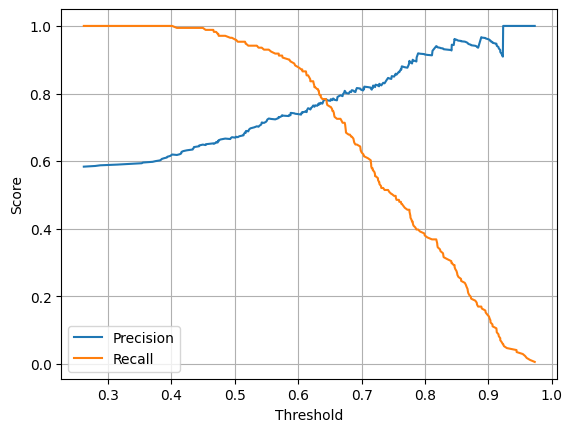

Intersection threshold: 0.644


In [7]:
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred)

plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Find intersection threshold
diff = abs(precisions[:-1] - recalls[:-1])
threshold_intersection = thresholds[np.argmin(diff)]
print("Intersection threshold:", round(threshold_intersection, 3))


---
## Question 4 — F1 Score

Best F1 threshold: 0.55


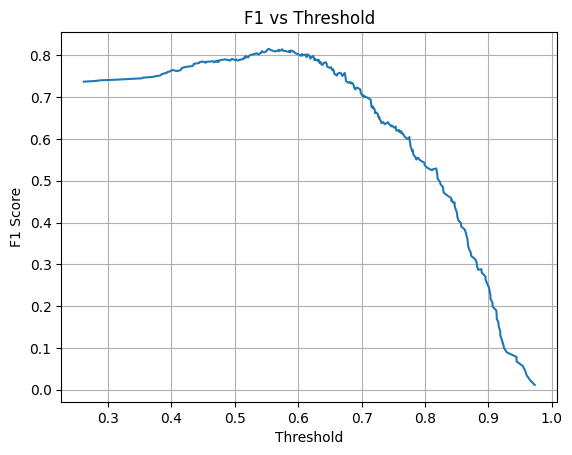

In [8]:
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1])
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print("Best F1 threshold:", round(best_threshold, 2))

plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 vs Threshold')
plt.grid(True)
plt.show()


---
## Question 5 — 5-Fold CV

In [9]:
df_full_train = df_full_train.reset_index(drop=True)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    train_dicts = df_train.drop('converted', axis=1).to_dict(orient='records')
    val_dicts = df_val.drop('converted', axis=1).to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print("Mean AUC:", round(np.mean(scores), 3))
print("Std of AUC:", round(np.std(scores), 3))


Mean AUC: 0.822
Std of AUC: 0.036


---
## Question 6 — Hyperparameter Tuning

In [10]:
C_values = [0.000001, 0.001, 1]
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in C_values:
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        train_dicts = df_train.drop('converted', axis=1).to_dict(orient='records')
        val_dicts = df_val.drop('converted', axis=1).to_dict(orient='records')

        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train_dicts)
        X_val = dv.transform(val_dicts)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print(f"C={C}: mean={round(np.mean(scores),3)}, std={round(np.std(scores),3)}")


C=1e-06: mean=0.56, std=0.024
C=0.001: mean=0.867, std=0.029
C=1: mean=0.822, std=0.036


---

## answering the obj question



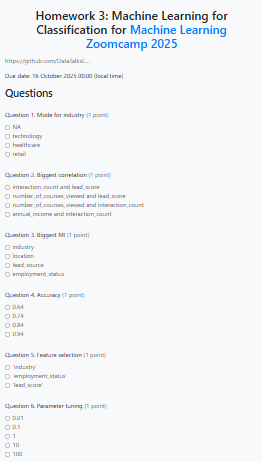

In [11]:
#what industry

df['industry'].mode()


0    retail
Name: industry, dtype: object

---

In [12]:
# QUESTION 2 Biggest correlation

num_cols = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
df[num_cols].corr()


,lead_score,number_of_courses_viewed,interaction_count,annual_income
lead_score,1.000000,-0.004879,0.009888,0.015610
number_of_courses_viewed,-0.004879,1.000000,-0.023565,0.009770
interaction_count,0.009888,-0.023565,1.000000,0.027036
annual_income,0.015610,0.009770,0.027036,1.000000


In [13]:
corr = df[['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']].corr()
corr_unstacked = corr.unstack().drop_duplicates()
corr_unstacked = corr_unstacked[corr_unstacked != 1]  # remove self-correlations
corr_unstacked.abs().idxmax()


('interaction_count', 'annual_income')

---
## QUESTION 3  Biggest Mutual Information (MI)

In [14]:
from sklearn.metrics import mutual_info_score

for col in ['industry', 'location', 'lead_source', 'employment_status']:
    mi = mutual_info_score(df[col], y)
    print(col, mi)


industry 0.007267435279688886
location 0.0014269064526338665
lead_source 0.026573987738060995
employment_status 0.011069560968622674


---
## QUESTION 4 ACCURACY

In [15]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(acc)


0.7510729613733905


---
## QUESTION 5 FEATURE SELECTION

In [19]:
feature_names = dv.get_feature_names_out()
selector = RFE(model, n_features_to_select=1)
selector.fit(X_train, y_train)

print(feature_names[selector.support_])


['lead_score']


---
QUESTION 6- PARAMETER TUNING

In [18]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression

for C in [0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    scores = cross_val_score(model, X_train, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=1), scoring='roc_auc')
    print(C, scores.mean(), scores.std())


0.01 0.8290251043878669 0.029753413902117873
0.1 0.8121840384628168 0.021236288848987366
1 0.8113828545359842 0.020862977794665803
10 0.8113110154555245 0.02089629224691185
100 0.8113110154555245 0.02089629224691185
